In [1]:
print("ok")

ok


In [ ]:
'''
Only first time I need that
'''
# Import library
import gdown

# Gdrive link
gdrive_url = "https://drive.google.com/file/d/1ECfl3dtYyfivY8kYPq7RHUBTjC-2vf61/view?usp=share_link"

# ID of the file you want to download
file_id = gdrive_url.split('/')[-2]
file_id

In [ ]:
# Download format
prefix = 'https://drive.google.com/uc?/export=download&id='

# Output you want
url = prefix+file_id
output = "../datasets/waste-material-dataset.zip"

In [ ]:
def download_file(file_url, output):
    try:
        # Download the file
        gdown.download(file_url, output)
        print('File downloaded successfully.')
    except Exception as e:
        print('An error occurred:', e)

In [ ]:
download_file(url, output)

In [ ]:
'''
Only first time I need that
'''
# Extract zip file
from zipfile import ZipFile

def extract_zip_files(file_name, unzip_path):
    try:
        with ZipFile(file_name, 'r') as file:
            print('Extract all the files...')
            file.extractall(path=unzip_path)
            print(f"Successfully extracted to {unzip_path}")
    except Exception as e:
        print(f"Extracting file error: {e}")

In [ ]:
'''
Only first time I need that
'''
file_name = "../datasets/waste-material-dataset.zip"
unzip_path = "../datasets"

extract_zip_files(file_name, unzip_path)

# I made a few strategies to deal with the dataset.

### 1. Understanding the Dataset
### 2. EDA
### 3. Image Processing on Bounding Box
### 4. Model Traning / Apply Transfer Learning
### 5. Model Validation, and Evaluation
### 6. Model Testing & Export
### 7. Model Monitoring and Maintaining

In [2]:
'''
Start here
'''
# Importing libraries
import numpy as np
import os, cv2, random
from collections import Counter, defaultdict
from tqdm import tqdm

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# Disable python warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load image and label directories
train_image_dir = "../datasets/train/images"
train_label_dir = "../datasets/train/labels"
valid_image_dir = "../datasets/valid/images"
valid_label_dir = "../datasets/valid/labels"

In [4]:
# Load yaml file
import yaml

with open("../datasets/data.yaml", "r") as f:
    dataset = yaml.load(f, Loader=yaml.FullLoader)

dataset

{'train': '../datasets/train/images',
 'val': '../datasets/valid/images',
 'nc': 13,
 'names': ['banana',
  'chilli',
  'drinkcan',
  'drinkpack',
  'foodcan',
  'lettuce',
  'paperbag',
  'plasticbag',
  'plasticbottle',
  'plasticcontainer',
  'sweetpotato',
  'teabag',
  'tissueroll']}

## 1. Understanding the Dataset

In [5]:

def explain_dataset(image_dir, label_dir, class_names, num_classes):
    
    # Storage variables
    image_count = 0
    label_count = 0
    image_not_count = 0
    total_bboxes = 0

    images_per_class = defaultdict(int)
    instances_per_class = defaultdict(int)
    objects_per_image = defaultdict(int)

    missing_label_files = []
    empty_label_files = []
    images_without_annotations = []
    bbox_areas = []

    
    for img_file in os.listdir(image_dir):
        if not img_file.lower().endswith((".jpg", ".png", ".jpeg")):
            image_not_count += 1
            continue
        
        image_count += 1
        image_name = os.path.splitext(img_file)[0]
        label_file = os.path.join(label_dir, f"{image_name}.txt")
        
        # Check if label file exists
        if not os.path.exists(label_file):
            missing_label_files.append(img_file)
            images_without_annotations.append(img_file)
            continue
        else:
            label_count += 1
        
        # Read annotate 
        with open(label_file, "r") as f:
            lines = f.readlines()
        
        if lines == [''] or len(lines) == 0:
            empty_label_files.append(img_file)
            images_without_annotations.append(img_file)
            continue
        
        # Count objects
        objects_per_image[img_file] = len(lines)
        total_bboxes += len(lines)
        
        # Count instances
        for line in lines:
            cls, x, y, w, h = map(float, line.split())
            cls = int(cls)
            
            instances_per_class[cls] += 1
            images_per_class[cls] += 1
            
            # Calculate bbox area
            bbox_area = w * h
            bbox_areas.append(bbox_area)
        
    # DISPLAY STATISTICS
    print("\n====== DATASET STATISTICS ======\n")
    print("Total images:", image_count)
    print("Total label files:", label_count)
    print("Images other formats:", image_not_count)
    print("Total bounding boxes:", total_bboxes)
    print("Average bounding-box size (normalized area):", 
        np.mean(bbox_areas) if bbox_areas else 0)

    print("\n=== IMAGES PER CLASS ===")
    for cls in range(num_classes):
        print(f"{cls} ({class_names[cls]}): {images_per_class[cls]} images")

    print("\n=== INSTANCES PER CLASS ===")
    for cls in range(num_classes):
        print(f"{cls} ({class_names[cls]}): {instances_per_class[cls]} instances")
    
    print("\n=== OBJECTS PER IMAGE ===")
    avg_objects_per_img = sum(objects_per_image.values()) / len(objects_per_image)
    print(f"Average objects per image: {avg_objects_per_img}")

    print("\nImages without annotation labels:", len(images_without_annotations))
    print("Missing label files:", len(missing_label_files))
    print("Empty label files:", len(empty_label_files))

In [6]:
class_names = dataset["names"]
num_classes = len(class_names)

explain_dataset(train_image_dir, train_label_dir, class_names, num_classes)


====== DATASET STATISTICS ======

Total images: 919
Total label files: 919
Images other formats: 0
Total bounding boxes: 1180
Average bounding-box size (normalized area): 0.31290798795021185

=== IMAGES PER CLASS ===
0 (banana): 79 images
1 (chilli): 71 images
2 (drinkcan): 94 images
3 (drinkpack): 91 images
4 (foodcan): 100 images
5 (lettuce): 90 images
6 (paperbag): 82 images
7 (plasticbag): 98 images
8 (plasticbottle): 99 images
9 (plasticcontainer): 90 images
10 (sweetpotato): 120 images
11 (teabag): 85 images
12 (tissueroll): 81 images

=== INSTANCES PER CLASS ===
0 (banana): 79 instances
1 (chilli): 71 instances
2 (drinkcan): 94 instances
3 (drinkpack): 91 instances
4 (foodcan): 100 instances
5 (lettuce): 90 instances
6 (paperbag): 82 instances
7 (plasticbag): 98 instances
8 (plasticbottle): 99 instances
9 (plasticcontainer): 90 instances
10 (sweetpotato): 120 instances
11 (teabag): 85 instances
12 (tissueroll): 81 instances

=== OBJECTS PER IMAGE ===
Average objects per image: 

## Train Dataset Observations:

- I'm using YOLO format to understand and analyze the dataset.
- The dataset contains two splits: train and valid.
- Each split contains two folders:
    - images/ → original images
    - labels/ → YOLO annotation files
- Each annotation file contains lines in the format:
- class x_center y_center width height, all values normalized.

## Understanding Images and Annotations

- Each image may contain one or more annotations, but in this dataset most images contain exactly one object.
- Each annotation is linked to only one image through the same filename.
- Class IDs range from 0 to 12, mapped to 13 categories like "banana", "chilli", "drinkcan", etc.
- The dataset appears to have one instance per image (based on total images = 919 and total instances = 1180, with very few multi-object images).

## Parsed and Computed Statistics

- Loaded all images and their corresponding YOLO annotation files.

- Counted:
    - Total number of images
    - Total number of labels (same count → perfectly consistent)
    - Total number of bounding boxes (1180)
    - Bounding-box sizes
    - Objects per image
    - Instances per class
    - Images per class
- Verified data consistency:
    - No missing labels
    - No empty label files
    - No images without annotations
    - No images are any other format
- Bounding box statistics:
    - Average normalized bbox area = 0.3129
    (meaning boxes are generally large relative to image size)

## Class Distribution

- Extracted category IDs and counted occurrences of each class.
- The dataset has 13 object categories:
    - The largest class is sweetpotato (120 instances).
    - The smallest class is chilli (71 instances).
- Class distribution is relatively balanced, with no extremely rare classes.

## Counting Objects Per Image

- Computed number of objects per image across both splits.
- Most images contain a single object, since total instances (1180) is only slightly higher than total images (919).
- The average number of objects per image ≈ 1.28.

## Conclusions:

- The dataset contains two YOLO-format splits: train and valid.
- Directory structure is consistent, containing:
    - images/
    - labels/
    - data.yaml defining the 13 class names.
- All images have corresponding label files:
    - 0 missing labels
    - 0 empty labels
    - 0 unannotated images
    - 0 image are other format
    - This indicates a clean and well-prepared dataset.
- Each annotation follows YOLO format with class IDs and normalized bounding boxes.
- The dataset contains:
    - 919 images
    - 919 label files
    - 1180 object instances
- Class distribution is balanced overall:
    - Highest: sweetpotato (120)
    - Lowest: chilli (71)
- Bounding boxes are generally large, with an average normalized area of ~0.31.
- On average, each image contains 1.28 objects, meaning the dataset is primarily single-object per image.
- Category names match the 13 waste/food-related classes:
banana, chilli, drinkcan, drinkpack, foodcan, lettuce, paperbag, plasticbag, plasticbottle, plasticcontainer, sweetpotato, teabag, tissueroll.

In [7]:
explain_dataset(valid_image_dir, valid_label_dir, class_names, num_classes)


====== DATASET STATISTICS ======

Total images: 459
Total label files: 459
Images other formats: 0
Total bounding boxes: 702
Average bounding-box size (normalized area): 0.2643136935763889

=== IMAGES PER CLASS ===
0 (banana): 46 images
1 (chilli): 55 images
2 (drinkcan): 49 images
3 (drinkpack): 51 images
4 (foodcan): 46 images
5 (lettuce): 57 images
6 (paperbag): 59 images
7 (plasticbag): 40 images
8 (plasticbottle): 61 images
9 (plasticcontainer): 52 images
10 (sweetpotato): 71 images
11 (teabag): 52 images
12 (tissueroll): 63 images

=== INSTANCES PER CLASS ===
0 (banana): 46 instances
1 (chilli): 55 instances
2 (drinkcan): 49 instances
3 (drinkpack): 51 instances
4 (foodcan): 46 instances
5 (lettuce): 57 instances
6 (paperbag): 59 instances
7 (plasticbag): 40 instances
8 (plasticbottle): 61 instances
9 (plasticcontainer): 52 instances
10 (sweetpotato): 71 instances
11 (teabag): 52 instances
12 (tissueroll): 63 instances

=== OBJECTS PER IMAGE ===
Average objects per image: 1.5294

## Valid Dataset Observations:

- I'm using YOLO format to understand and analyze the dataset.
- The dataset contains two splits: train and valid.
- Each split contains two folders:
    - images/ → original images
    - labels/ → YOLO annotation files
- Each annotation file contains lines in the format:
- class x_center y_center width height, all values normalized.

## Understanding Images and Annotations

- Each image may contain one or more annotations, but in this dataset most images contain exactly one object.
- Each annotation is linked to only one image through the same filename.
- Class IDs range from 0 to 12, mapped to 13 categories like "banana", "chilli", "drinkcan", etc.
- The dataset appears to have one instance per image (based on total images = 459 and total instances = 702, with very few multi-object images).

## Parsed and Computed Statistics

- Loaded all images and their corresponding YOLO annotation files.

- Counted:
    - Total number of images
    - Total number of labels (same count → perfectly consistent)
    - Total number of bounding boxes (702)
    - Bounding-box sizes
    - Objects per image
    - Instances per class
    - Images per class
- Verified data consistency:
    - No missing labels
    - No empty label files
    - No images without annotations
    - No images are any other format
- Bounding box statistics:
    - Average normalized bbox area = 0.2643
    (meaning boxes are generally large relative to image size)

## Class Distribution

- Extracted category IDs and counted occurrences of each class.
- The dataset has 13 object categories:
    - The largest class is tissueroll (63 instances).
    - The smallest class is plasticbag (40 instances).
- Class distribution is relatively balanced, with no extremely rare classes.

## Counting Objects Per Image

- Computed number of objects per image across both splits.
- Most images contain a single object, since total instances (702) is only slightly higher than total images (459).
- The average number of objects per image ≈ 1.52.

## Conclusions:

- The dataset contains two YOLO-format splits: train and valid.
- Directory structure is consistent, containing:
    - images/
    - labels/
    - data.yaml defining the 13 class names.
- All images have corresponding label files:
    - 0 missing labels
    - 0 empty labels
    - 0 unannotated images
    - 0 image are other format
    - This indicates a clean and well-prepared dataset.
- Each annotation follows YOLO format with class IDs and normalized bounding boxes.
- The dataset contains:
    - 459 images
    - 459 label files
    - 702 object instances
- Class distribution is balanced overall:
    - Highest: tissueroll (63)
    - Lowest: plasticbag (40)
- Bounding boxes are generally large, with an average normalized area of ~0.31.
- On average, each image contains 1.28 objects, meaning the dataset is primarily single-object per image.
- Category names match the 13 waste/food-related classes:
banana, chilli, drinkcan, drinkpack, foodcan, lettuce, paperbag, plasticbag, plasticbottle, plasticcontainer, sweetpotato, teabag, tissueroll.

## 2. EDA

In [8]:
def object_class_distribution_and_percentage_analysis(class_names, instances_per_class, num_classes):
    plt.figure(figsize=(12,6))
    sns.barplot(x=list(class_names), y=[instances_per_class[i] for i in range(num_classes)], palette="viridis")
    plt.xticks(rotation=45)
    plt.title("Instances per Class")
    plt.show()

    # Percentage
    total_objects = sum(instances_per_class.values())
    percentages = {class_names[i]: (instances_per_class[i]/total_objects*100) for i in range(num_classes)}
    categoies = list(percentages.keys())
    values = list(percentages.values())

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=categoies, autopct="%1.2f%%",  startangle=90, shadow=True, labeldistance=1.1, pctdistance=0.6)
    plt.title("Class Percentage Distribution")
    plt.show()

In [9]:
def area_distribution_analysis(bbox_areas, bbox_widths, bbox_heights, bbox_centers):
    plt.figure(figsize=(8,5))
    sns.histplot(bbox_areas, bins=20, kde=True)
    plt.title("Bounding Box Area Distribution (normalized)")
    plt.show()

    # Width distribution
    plt.figure(figsize=(8,5))
    sns.histplot(bbox_widths, bins=20, kde=True)
    plt.title("Bounding Box Width Distribution")
    plt.show()

    # Height distribution
    plt.figure(figsize=(8,5))
    sns.histplot(bbox_heights, bins=20, kde=True)
    plt.title("Bounding Box Height Distribution")
    plt.show()

    # Heatmap of bbox centers
    xs = [c[0] for c in bbox_centers]
    ys = [c[1] for c in bbox_centers]
    plt.figure(figsize=(6,6))
    sns.kdeplot(x=xs, y=ys, fill=True, cmap="Reds")
    plt.title("Bounding Box Center Heatmap")
    plt.show()

In [10]:
def image_resolution_analysis(image_info):
    widths = [w for _, w, _ in image_info]
    heights = [h for _, _, h in image_info]

    plt.figure(figsize=(8,6))
    plt.scatter(widths, heights, alpha=0.4)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.title("Image Resolution Distribution")
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, density=True)
    plt.xlabel("Width")
    plt.ylabel("Density")
    plt.title("Width Distribution")

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20, density=True)
    plt.xlabel("Height")
    plt.ylabel("Density")
    plt.title("Height Distribution")
    plt.show()

    print("Average resolution:", (round(np.mean(widths), 2), round(np.mean(heights), 2)))

In [11]:
# Plot bounding box area size distribution
def bbx_size(bbox_areas, aspect_ratios):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(bbox_areas, bins=20, kde=True)
    plt.title('Bounding Box Area Distribution')
    
    plt.subplot(1, 2, 2)
    sns.histplot(aspect_ratios, bins=20, kde=True)
    plt.title('Bounding Box Aspect Ratio Distribution')

    plt.tight_layout()
    plt.show()
    
    print(f"Bounding box area distribution: {np.percentile(bbox_areas, [25, 50, 75])}")
    print(f"Aspect ratio distribution: {np.percentile(aspect_ratios, [25, 50, 75])}")

In [12]:
def outlier_analysis(bbox_areas):
    areas = np.array(bbox_areas)
    mean_area = np.mean(areas)
    std_area = np.std(areas)
    outliers = np.where((areas > mean_area + 3*std_area) | (areas < mean_area - 3*std_area))[0]

    print("\nBounding box outliers:", len(outliers))

    plt.figure(figsize=(8,5))
    sns.boxplot(x=areas)
    plt.title("Boxplot of Normalized BBox Area")
    plt.show()

In [13]:
def co_occurrence_analysis(co_occurrence, class_names, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)

    for c1 in co_occurrence:
        for c2 in co_occurrence[c1]:
            matrix[int(c1)][int(c2)] = co_occurrence[c1][c2]

    plt.figure(figsize=(12,10))
    sns.heatmap(matrix, xticklabels=class_names, yticklabels=class_names, cmap="Blues", annot=True)
    plt.title("Class Co-occurrence Heatmap")
    plt.show()

In [14]:
def show_random_samples(annotations, n=3):
    samples = random.sample(annotations, n)
    
    for img_path, cls, xc, yc, bw, bh in samples:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load: {img_path}")
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print(f"Image format: {img.dtype}, Image size: {img.size}, Image shape: {img.shape}")
        
        h, w = img.shape[:2]
        
        # Numeric values
        xc, yc, bw, bh = map(float, (xc, yc, bw, bh))

        x1 = (xc - bw/2) * w
        y1 = (yc - bh/2) * h
        width = bw * w
        height = bh * h
        
        # clamp to image bounds
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(w, x1 + width)
        y2 = min(h, y1 + height)
        
        width = x2 - x1
        height = y2 - y1
        
        # Draw everyhing on the same figure
        plt.figure(figsize=(6,6))
        ax = plt.gca()
        plt.imshow(img)
        
        rect = patches.Rectangle(
            (x1, y1), width, height, 
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        
        plt.text(x1, max(0, y1-5), class_names[int(cls)], 
                 fontsize=12, color='r', bbox=dict(facecolor='yellow', alpha=0.5)
        )
        
        plt.axis("off")
        plt.show()

In [15]:

def parse_dataset(image_dir, label_dir, class_names, num_classes):
    
    # Storage variables
    image_info = []
    annotations = []
    image_not_count = 0

    objects_per_image = Counter()
    instances_per_class = Counter()
    co_occurrence = defaultdict(lambda: Counter())

    missing_labels = []
    empty_annotations = []
    bbox_areas = []
    aspect_ratios = []
    bbox_widths = []
    bbox_heights = []
    bbox_centers = []
    
    for img_file in tqdm(os.listdir(image_dir)):
        if not img_file.lower().endswith((".jpg", ".png", ".jpeg")):
            image_not_count += 1
            continue
        
        img_path = os.path.join(image_dir, img_file)
        label_path = os.path.join(label_dir, img_file.rsplit(".",1)[0] + ".txt")
        
        # Load image resolution
        img = cv2.imread(img_path)
        
        if img is None:
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_h, img_w = img.shape[:2]
        image_info.append((img_path, img_w, img_h))
        
        # Check annotations
        if not os.path.exists(label_path):
            missing_labels.append(img_path)
            continue
        
        with open(label_path, "r") as f:
            lines = [l.strip() for l in f.readlines() if l.strip()]
        
        if len(lines) == 0:
            empty_annotations.append(img_path)
            continue
        
        objects_per_image[img_path] = len(lines)
        
        # Track which classes in this image
        present_classes = set()
        
        for line in lines:
            cls, xc, yc, bw, bh = map(float, line.split())
            
            bbox_widths.append(bw)
            bbox_heights.append(bh)
            bbox_centers.append((xc, yc))
            
            bbox_area = bw * bh
            bbox_areas.append(bbox_area)
            
            aspect_ratio = bw / bh
            aspect_ratios.append(aspect_ratio)
            
            annotations.append((img_path, cls, xc, yc, bw, bh))
            present_classes.add(cls)
            instances_per_class[cls] += 1
            
            for c in present_classes:
                co_occurrence[int(cls)][int(c)] += 1
        
        for c1 in present_classes:
            for c2 in present_classes:
                if c1 != c2:
                    co_occurrence[c1][c2] += 1
    
    print("\n=== MISSING LABELS ===")
    print("Missing labels:", len(missing_labels))
    
    print("\n=== EMPTY ANNOTATIONS ===")
    print("Empty annotations:", len(empty_annotations))
    
    print("\n=== CLASS DISTRIBUTION ===")
    object_class_distribution_and_percentage_analysis(class_names, instances_per_class, num_classes)
    
    print("\n=== BOUNDING BOX ANALYSIS ===")
    area_distribution_analysis(bbox_areas, bbox_widths, bbox_heights, bbox_centers)
    
    print("\n=== IMAGE RESOLUTION ANALYSIS ===")
    image_resolution_analysis(image_info)
    
    print("\n=== AREA SIZE ===")
    bbx_size(bbox_areas, aspect_ratios)
    
    print("\n=== OUTLIERS ===")
    outlier_analysis(bbox_areas)
    
    print("\n=== CO-OCCURRENCE ===")
    co_occurrence_analysis(co_occurrence, class_names, num_classes)
    
    print("\n=== RANDOM SAMPLES ===")
    show_random_samples(annotations)

100%|██████████| 459/459 [00:18<00:00, 25.37it/s]



=== MISSING LABELS ===
Missing labels: 0

=== EMPTY ANNOTATIONS ===
Empty annotations: 0

=== CLASS DISTRIBUTION ===


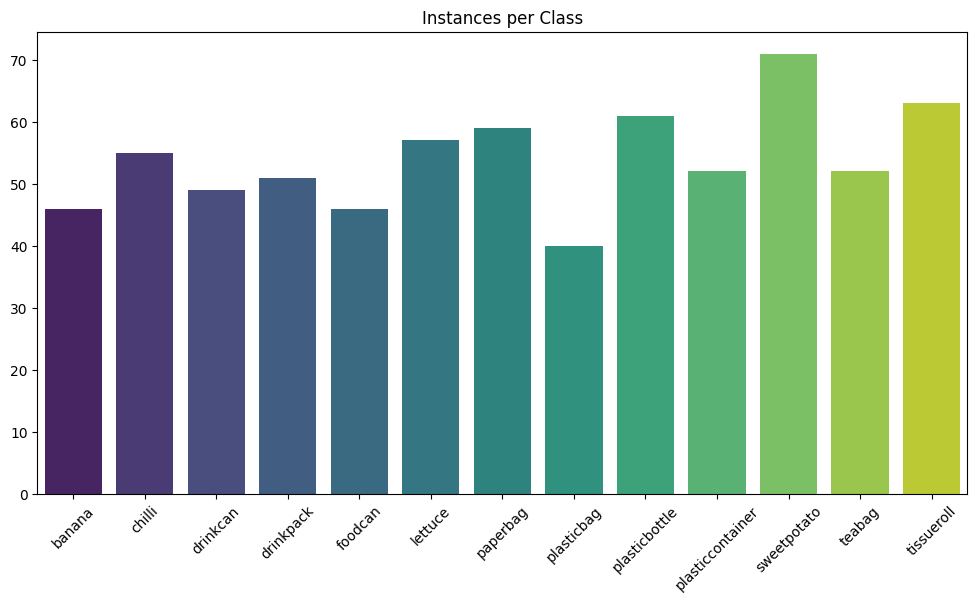

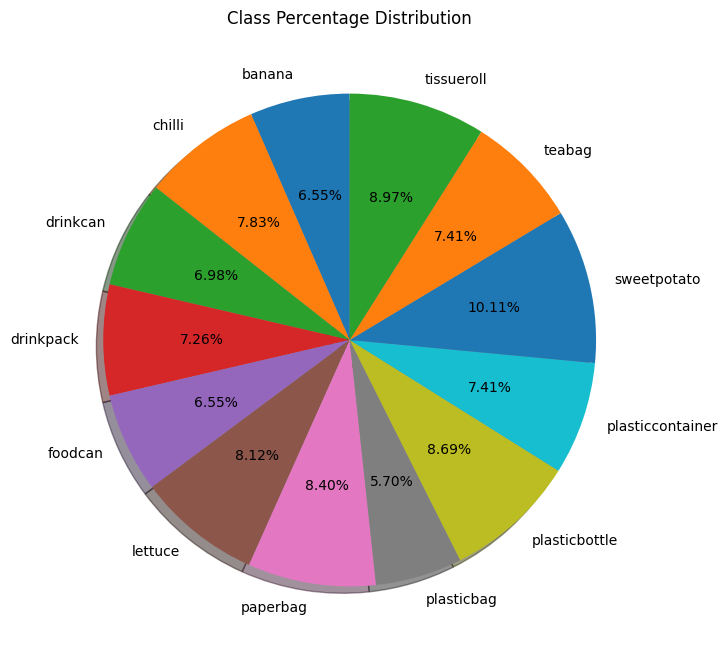


=== BOUNDING BOX ANALYSIS ===


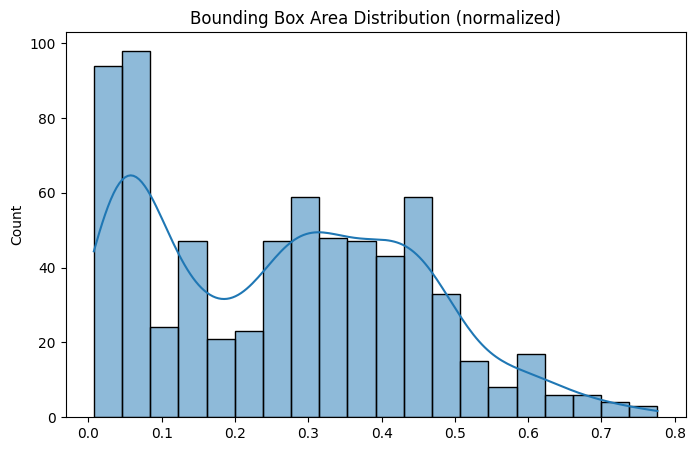

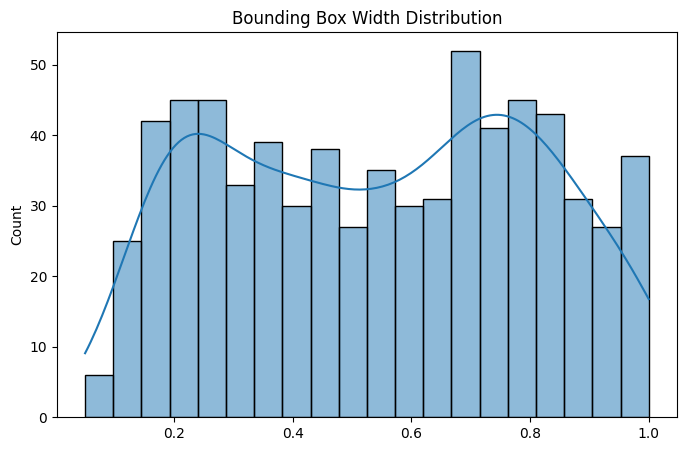

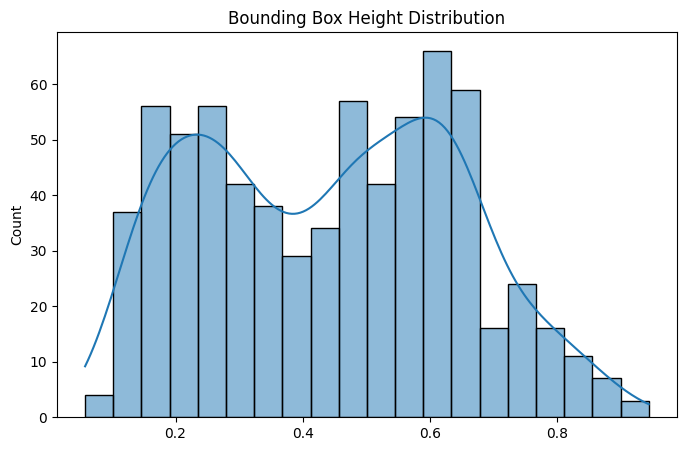

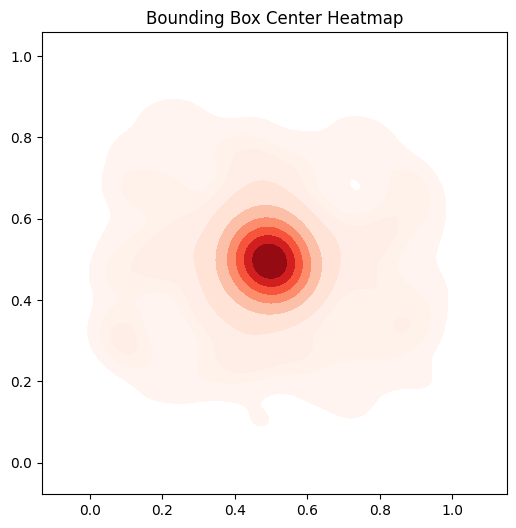


=== IMAGE RESOLUTION ANALYSIS ===


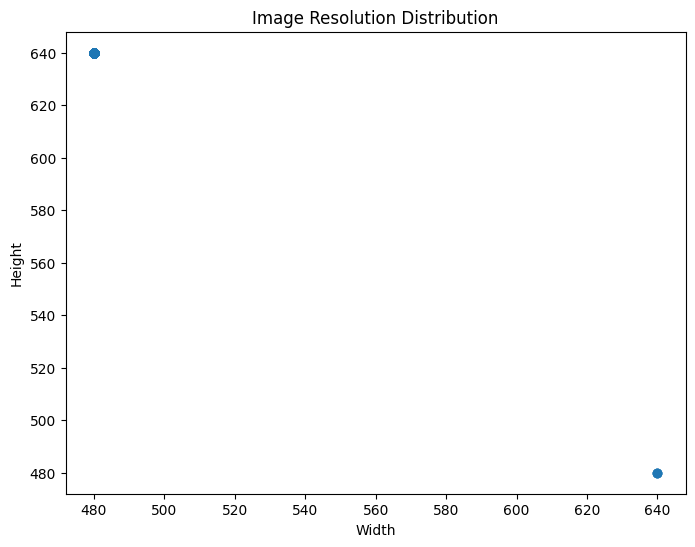

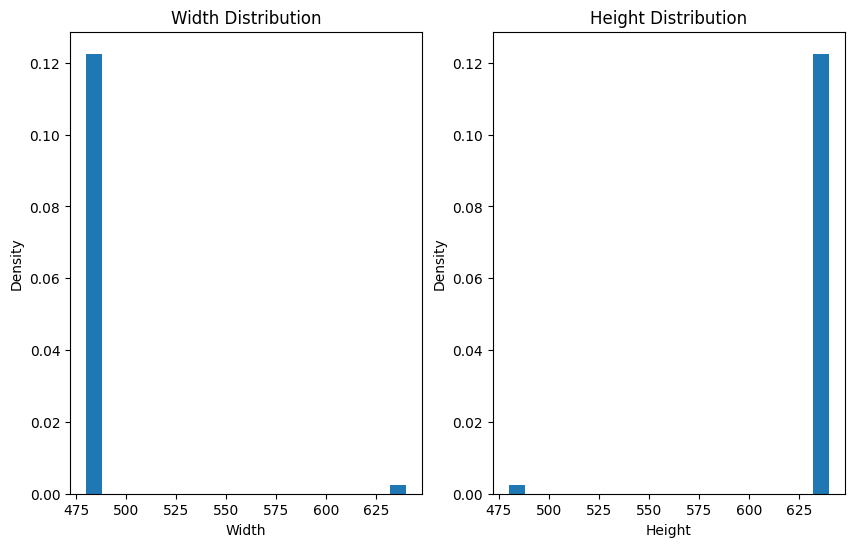

Average resolution: (np.float64(483.14), np.float64(636.86))

=== AREA SIZE ===


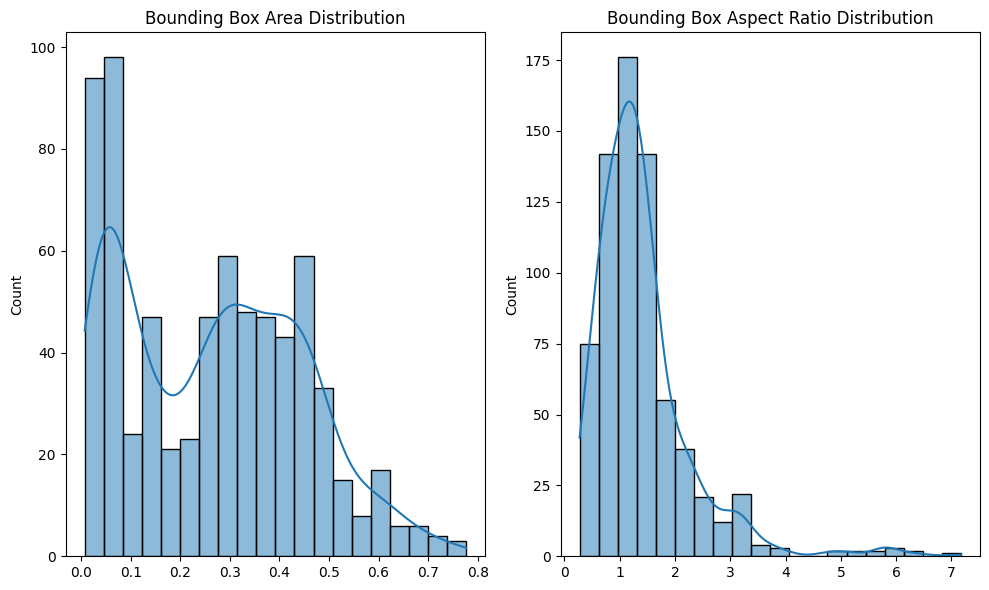

Bounding box area distribution: [0.07549479 0.27495443 0.410743  ]
Aspect ratio distribution: [0.86031437 1.21615878 1.61539682]

=== OUTLIERS ===

Bounding box outliers: 0


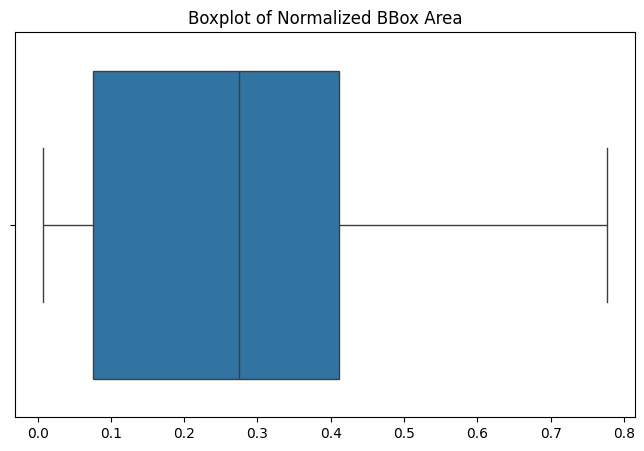


=== CO-OCCURRENCE ===


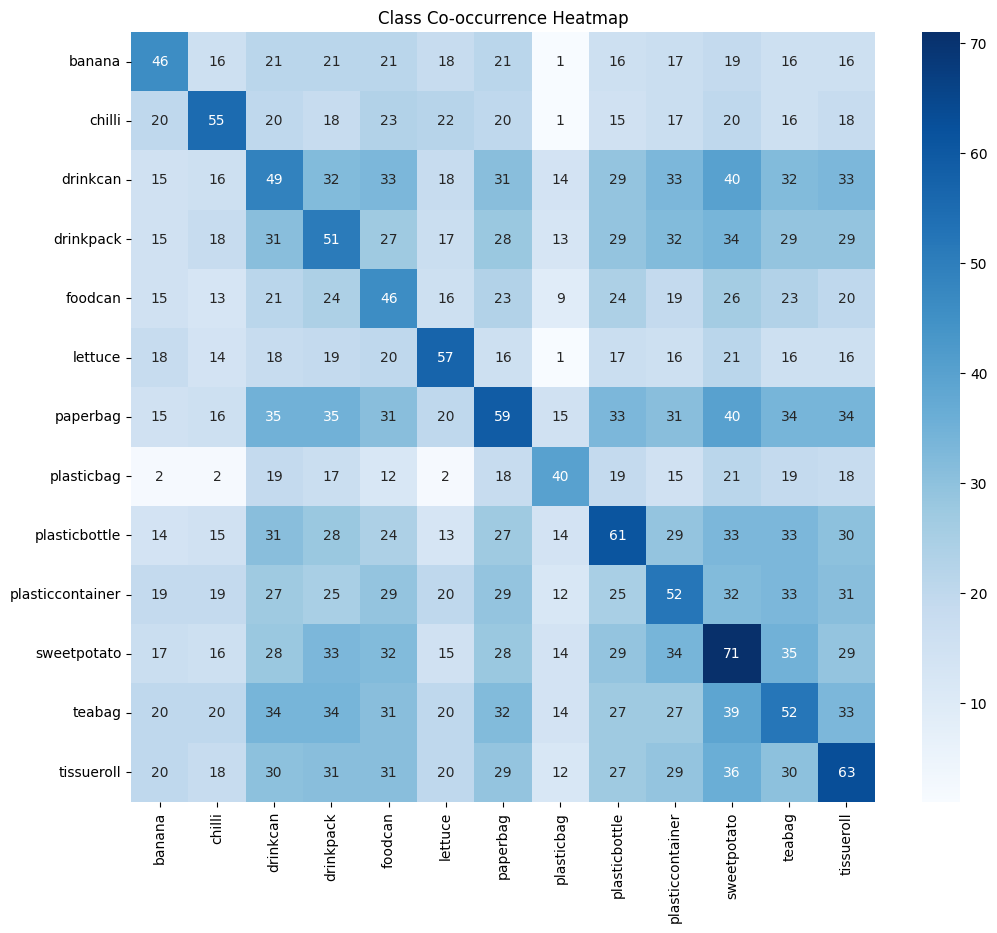


=== RANDOM SAMPLES ===
Image format: uint8, Image size: 921600, Image shape: (640, 480, 3)


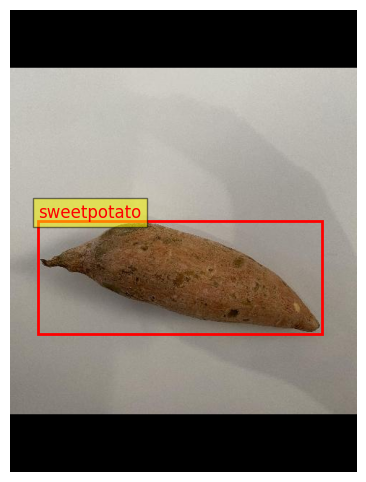

Image format: uint8, Image size: 921600, Image shape: (480, 640, 3)


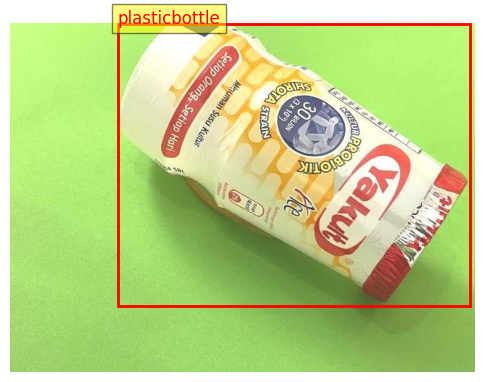

Image format: uint8, Image size: 921600, Image shape: (640, 480, 3)


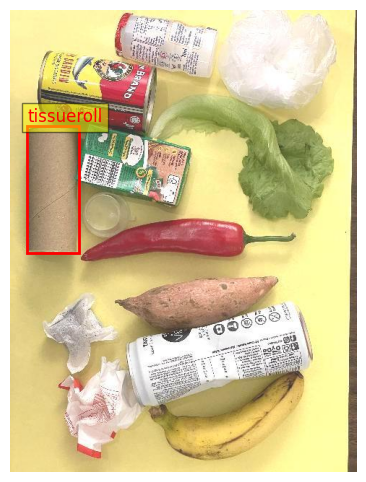

In [16]:
# Valid dataset
class_names = dataset["names"]
num_classes = len(class_names)

parse_dataset(valid_image_dir, valid_label_dir, class_names, num_classes)

In [ ]:
# Counting objects per image
def img_count(image_dir, label_dir):
    objects_per_image = defaultdict(int)
    
    for img_file in os.listdir(image_dir):
        image_name = os.path.splitext(img_file)[0]
        label_file = os.path.join(label_dir, f"{image_name}.txt")
                
        # Read annotate 
        with open(label_file, "r") as f:
            lines = f.readlines()
        
        if lines == [''] or len(lines) == 0:
            continue
        
        # Count objects
        objects_per_image[img_file] = len(lines)
        
    return objects_per_image

In [18]:
def plot_histogram(objects_per_count):
    sns.histplot(objects_per_count, kde=True)
    plt.title('Objects per Image Distribution')
    plt.show()

In [ ]:
def object_count_distribution(image_dir, label_dir):
    # Dataset object per image count
    data_object_count = img_count(image_dir, label_dir)
    print(f"Object per image: {Counter(data_object_count.values())}")
    object_count_values = list(data_object_count.values())

    plot_histogram(object_count_values)

    return data_object_count

Object per image: Counter({1: 427, 12: 12, 2: 10, 11: 8, 13: 1, 10: 1})


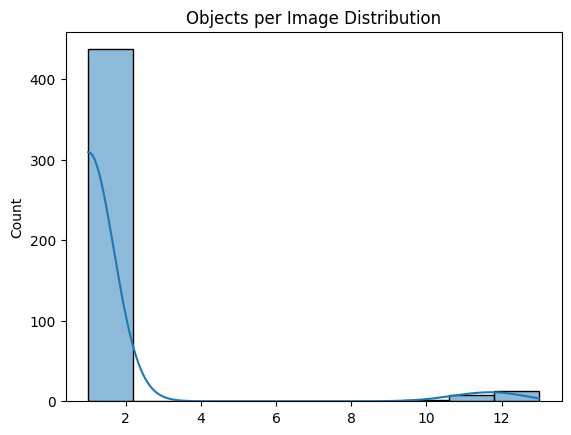

In [20]:
# Valid dataset object per image count

valid_object_count = object_count_distribution(valid_image_dir, valid_label_dir)

In [21]:
def images_with_multiple_objects(object_count, category_id):
    data_multiple_objects = [image_id for image_id, count in object_count.items() if count == category_id]

    print(f"Images with {category_id} objects: {data_multiple_objects}")
    print(f"Images total lengths with multiple objects: {len(data_multiple_objects)}")

In [22]:
# Valid dataset Identify images with 2 or more objects
images_with_multiple_objects(valid_object_count, 11)

Images with 11 objects: ['Mixed_13_jpg.rf.8aafe3f82286025e05e86eb64af58ae8.jpg', 'Mixed_13_jpg.rf.f4e8b46997277b9683bb913f97a4b4de.jpg', 'Mixed_4_JPG_jpg.rf.94c0706b7c6d575fdd7e73d21a9b894f.jpg', 'Mixed_7_JPG_jpg.rf.9b401f3f2b8d8a64321883e9dc95c934.jpg', 'Mixed_8_JPG_jpg.rf.71de234ad9112ab49b5f8030f55c9e51.jpg', 'Mixed_8_JPG_jpg.rf.d94f29521a0b2f163cf056042d7d50aa.jpg', 'Mixed_8_JPG_jpg.rf.e898444c5978745e1548a3118e6d1b09.jpg', 'Mixed_9_JPG_jpg.rf.5fb080547941412604db6b9d21612804.jpg']
Images total lengths with multiple objects: 8


## Valid Dataset Observations:

- Plot a graph of the 'Number of Objects' and 'Categories'. I've many categories of: 'Waste Material'.
    - The validation dataset contains 13 different object categories.
    - The distribution of objects across categories shows class imbalance, with some categories appearing more frequently than others.
- Plot a bounding box width and height distributions.
    - Bounding box width and height distributions indicate that most objects occupy a moderate-to-large portion of the image.
    - The histograms show the normalized bounding box width and height values.
- Plot an Image size distribution graph
    - All validation images have a fixed resolution of 640 × 480 pixels.
    - No variation in image size is observed across the validation dataset.
- Plot a graph of bounding box annotation visualization
    - We know about the images format, size, and shape: Image format: uint8, Image size: 921600, Image shape: (640, 480, 3)
    - Visualized samples confirm that bounding boxes are correctly aligned with objects.
    - Some images contain multiple bounding boxes, indicating the presence of more than one object per image.
- Plot a graph of bounding box area size and aspect ratio distribution
    - Bounding box area distribution shows that most objects have relatively large bounding box areas compared to the image size.
    - Aspect ratio distribution indicates that most bounding boxes are close to square.
    - The histograms of bounding box area and aspect ratio values are right-skewed.
- Plot a bounding box area size and aspect ratio distribution
    - Bounding box area distribution shows that most objects have relatively large bounding box areas compared to the image size.
    - Aspect ratio distribution indicates that most bounding boxes are close to square.
    - The histograms of bounding box area and aspect ratio values are right-skewed.
- Plot a graph of object per image count
    - The validation dataset contains both single-object and multi-object images.
    - Object-per-image count for the validation dataset: Object per image: Counter({1: 427, 12: 12, 2: 10, 11: 8, 13: 1, 10: 1})


## Conclusions:

- The validation dataset contains 13 object categories, covering various waste and food-related classes.
- The number of objects per category is imbalanced, which may influence validation performance across different classes.
- Bounding box width, height, and area distributions indicate that objects are generally moderate to large in size, simplifying object localization compared to datasets dominated by small objects.
- All images have a uniform resolution of 640 × 480 pixels, which ensures consistent input dimensions during model validation.
- Bounding box annotation visualizations confirm that annotations are accurate and properly aligned with the objects in the images.
- Bounding box area and aspect ratio distributions show that most objects are square-shaped, with few extreme aspect ratios.
- Object-per-image analysis shows that many validation images contain multiple object instances, increasing scene complexity.
- The presence of multiple objects and class imbalance in the validation dataset may impact validation metrics, particularly for less frequent categories.
- Overall, the validation dataset is clean, well-annotated, and suitable for evaluating YOLO-based object detection models, while requiring careful interpretation of results due to class imbalance and varying object counts per image.
- Category names match the 13 waste/food-related classes:
banana, chilli, drinkcan, drinkpack, foodcan, lettuce, paperbag, plasticbag, plasticbottle, plasticcontainer, sweetpotato, teabag, tissueroll.

100%|██████████| 919/919 [00:36<00:00, 25.21it/s]



=== MISSING LABELS ===
Missing labels: 0

=== EMPTY ANNOTATIONS ===
Empty annotations: 0

=== CLASS DISTRIBUTION ===


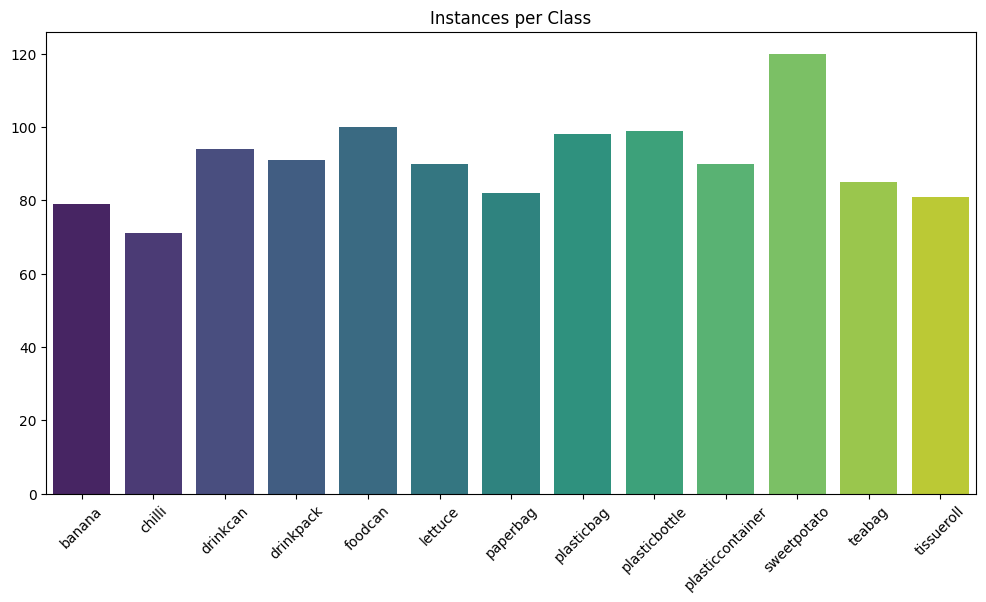

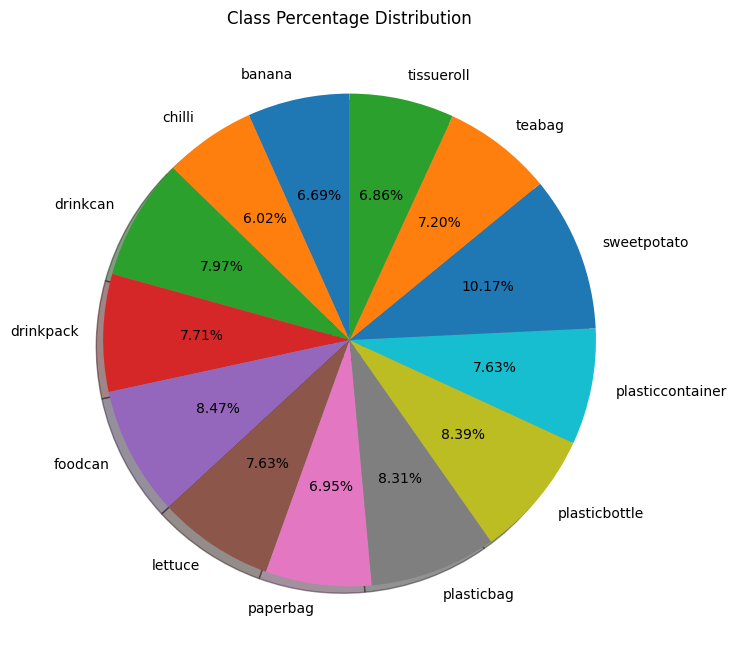


=== BOUNDING BOX ANALYSIS ===


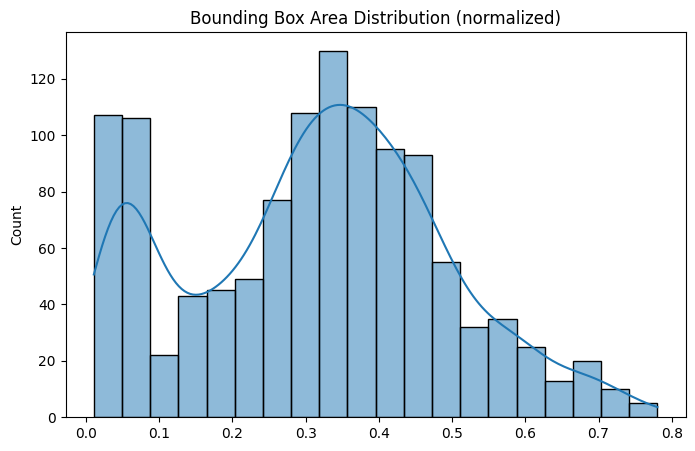

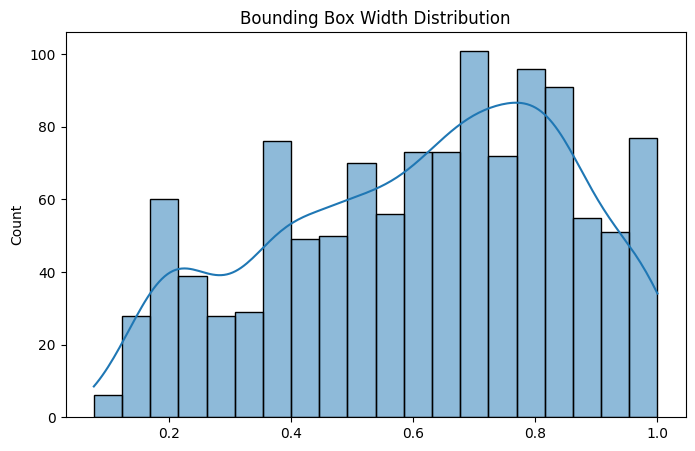

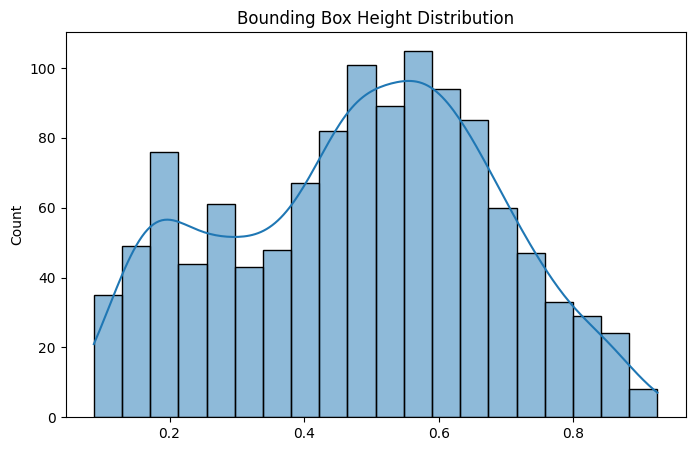

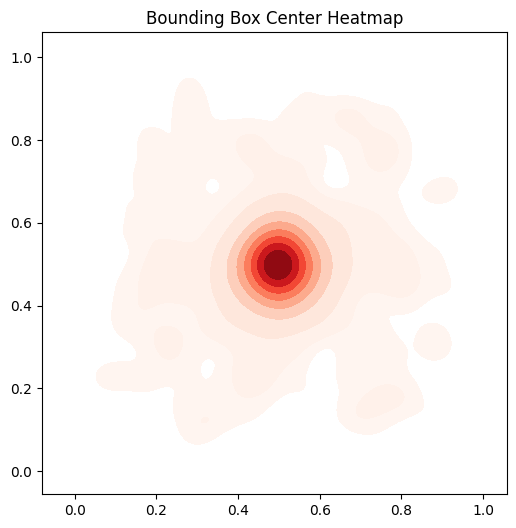


=== IMAGE RESOLUTION ANALYSIS ===


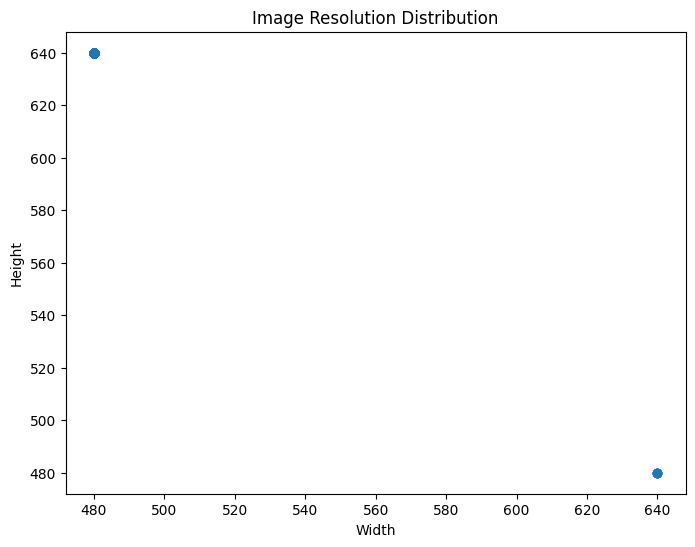

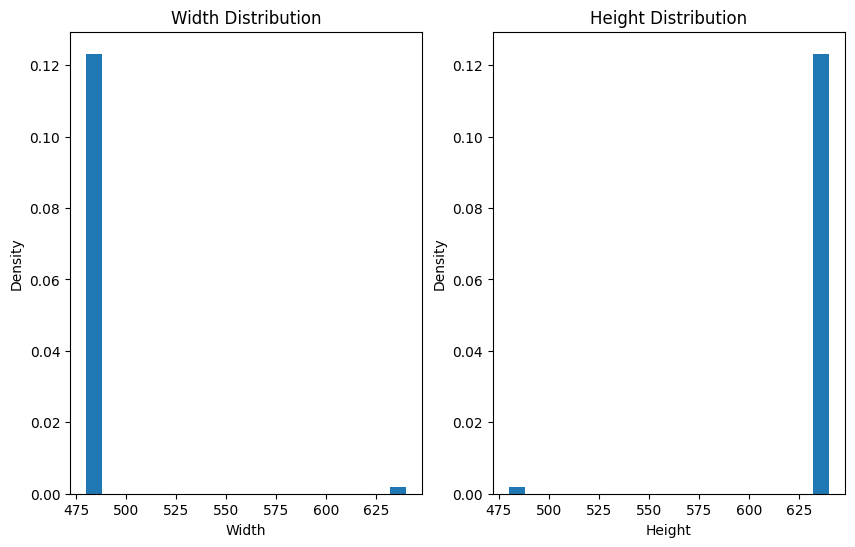

Average resolution: (np.float64(482.26), np.float64(637.74))

=== AREA SIZE ===


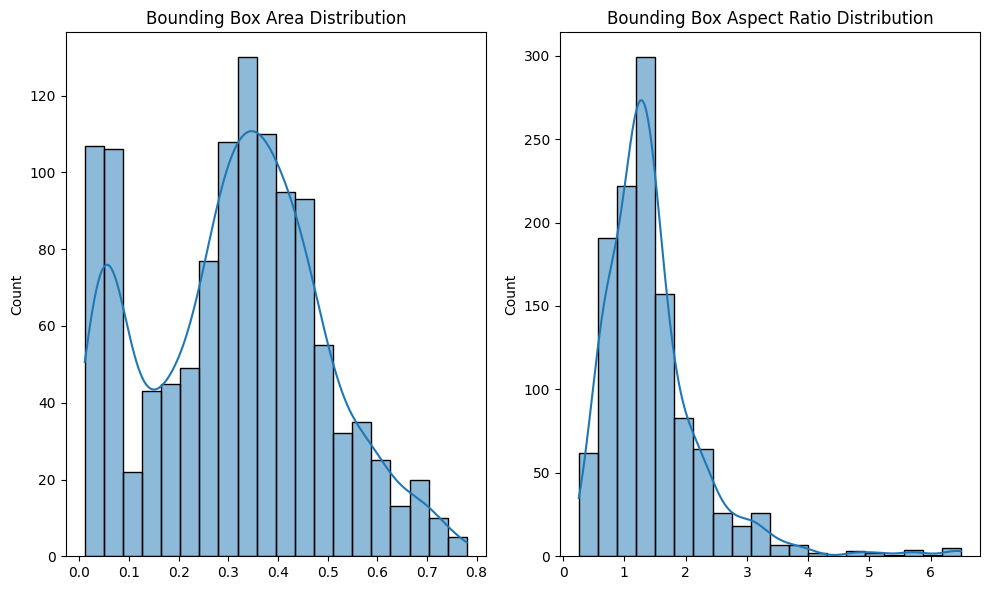

Bounding box area distribution: [0.18212891 0.32738607 0.42910645]
Aspect ratio distribution: [0.984375   1.31101288 1.68551898]

=== OUTLIERS ===

Bounding box outliers: 0


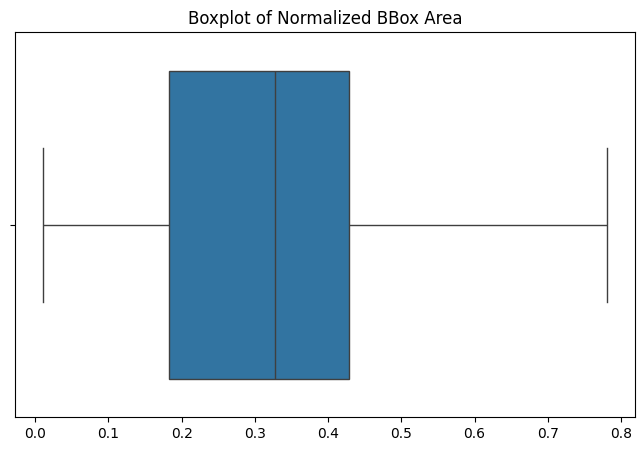


=== CO-OCCURRENCE ===


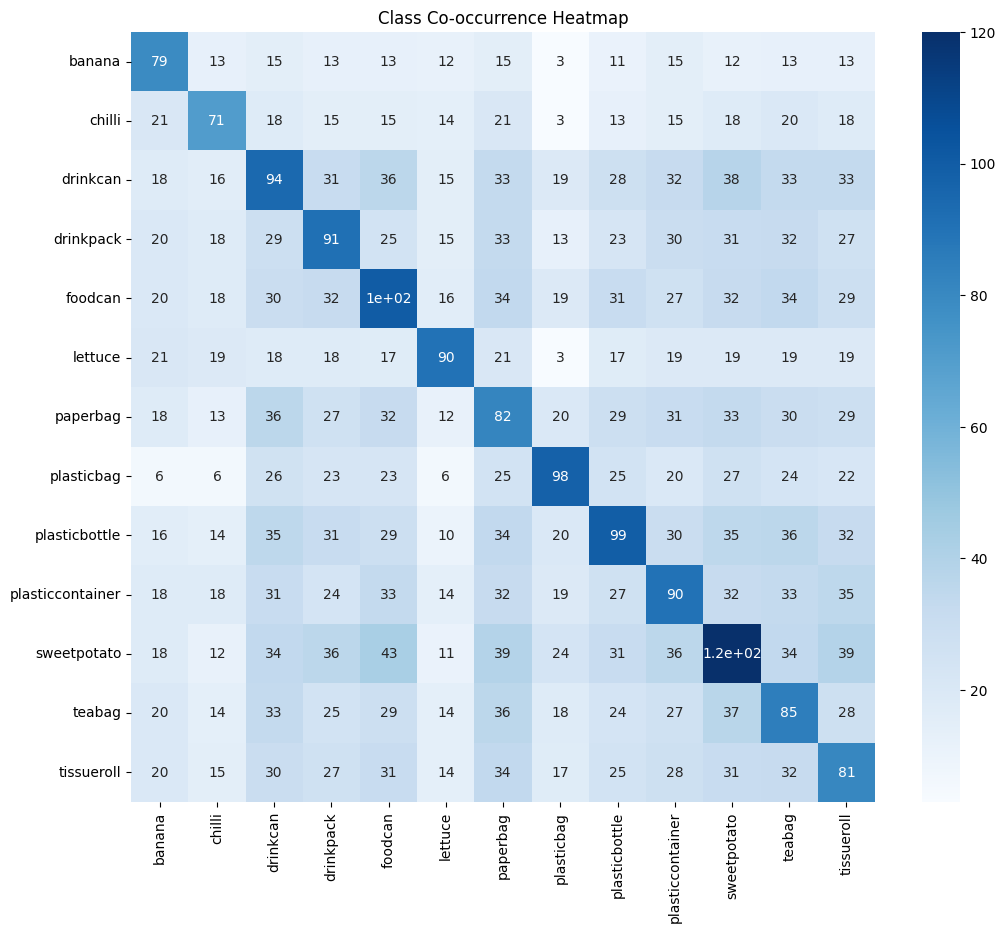


=== RANDOM SAMPLES ===
Image format: uint8, Image size: 921600, Image shape: (640, 480, 3)


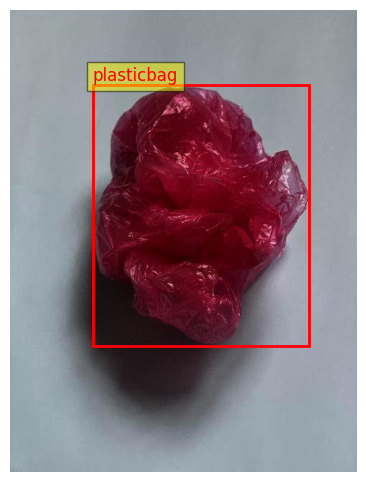

Image format: uint8, Image size: 921600, Image shape: (640, 480, 3)


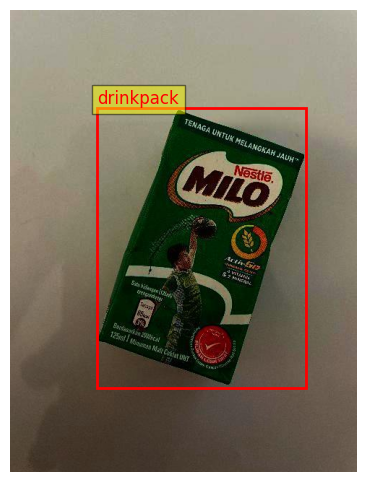

Image format: uint8, Image size: 921600, Image shape: (640, 480, 3)


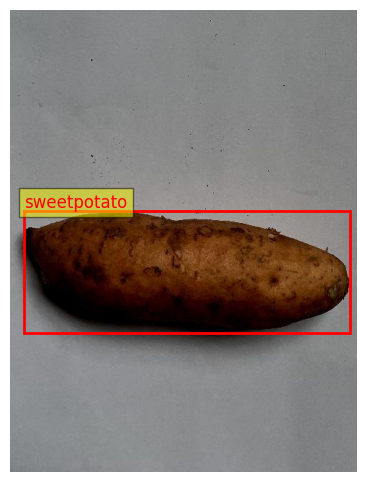

In [23]:
# Train dataset
class_names = dataset["names"]
num_classes = len(class_names)

parse_dataset(train_image_dir, train_label_dir, class_names, num_classes)

Object per image: Counter({1: 880, 2: 16, 12: 11, 11: 7, 13: 3, 10: 2})


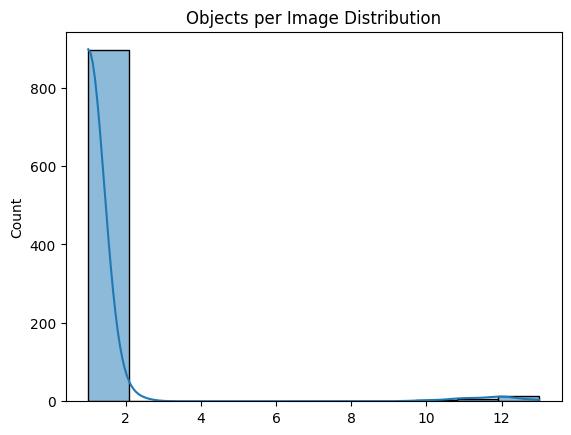

In [24]:
# Train dataset object per image count

train_object_count = object_count_distribution(train_image_dir, train_label_dir)

In [25]:
# Valid dataset Identify images with 2 or more objects
images_with_multiple_objects(train_object_count, 13)

Images with 13 objects: ['Mixed_29_jpg.rf.5675bf476d3cc01bd62f336547c4dfcd.jpg', 'Mixed_29_jpg.rf.97e818514d55416dfdfb97896095f6af.jpg', 'Mixed_29_jpg.rf.fc95f87477c968fc5e9b943971d2ceac.jpg']
Images total lengths with multiple objects: 3


## Train Dataset Observations:

- Plot a graph of the 'Number of Objects' and 'Categories'. I've many categories of: 'Waste Material'.
    - The train dataset contains 13 different object categories.
    - The distribution of objects across categories shows class imbalance, with some categories appearing more frequently than others.
- Plot a bounding box width and height distributions.
    - Bounding box width and height distributions indicate that most objects occupy a moderate-to-large portion of the image.
    - The histograms show the normalized bounding box width and height values.
- Plot an Image size distribution graph
    - All train images have a fixed resolution of 640 × 480 pixels.
    - No variation in image size is observed across the train dataset.
- Plot a graph of bounding box annotation visualization
    - We know about the images format, size, and shape: Image format: uint8, Image size: 921600, Image shape: (640, 480, 3)
    - Visualized samples confirm that bounding boxes are correctly aligned with objects.
    - Some images contain multiple bounding boxes, indicating the presence of more than one object per image.
- Plot a graph of bounding box area size and aspect ratio distribution
    - Bounding box area distribution shows that most objects have relatively large bounding box areas compared to the image size.
    - Aspect ratio distribution indicates that most bounding boxes are close to square.
    - The histograms of bounding box area and aspect ratio values are right-skewed.
- Plot a bounding box area size and aspect ratio distribution
    - Bounding box area distribution shows that most objects have relatively large bounding box areas compared to the image size.
    - Aspect ratio distribution indicates that most bounding boxes are close to square.
    - The histograms of bounding box area and aspect ratio values are right-skewed.
- Plot a graph of object per image count
    - The train dataset contains both single-object and multi-object images.
    - Object-per-image count for the train dataset: Object per image: Counter({1: 880, 2: 16, 12: 11, 11: 7, 13: 3, 10: 2})


## Conclusions:

- The train dataset contains 13 object categories, covering various waste and food-related classes.
- The number of objects per category is imbalanced, which may influence train performance across different classes.
- Bounding box width, height, and area distributions indicate that objects are generally moderate to large in size, simplifying object localization compared to datasets dominated by small objects.
- All images have a uniform resolution of 640 × 480 pixels, which ensures consistent input dimensions during model train.
- Bounding box annotation visualizations confirm that annotations are accurate and properly aligned with the objects in the images.
- Bounding box area and aspect ratio distributions show that most objects are square-shaped, with few extreme aspect ratios.
- Object-per-image analysis shows that many train images contain multiple object instances, increasing scene complexity.
- The presence of multiple objects and class imbalance in the train dataset may impact train metrics, particularly for less frequent categories.
- Overall, the train dataset is clean, well-annotated, and suitable for evaluating YOLO-based object detection models, while requiring careful interpretation of results due to class imbalance and varying object counts per image.
- Category names match the 13 waste/food-related classes:
banana, chilli, drinkcan, drinkpack, foodcan, lettuce, paperbag, plasticbag, plasticbottle, plasticcontainer, sweetpotato, teabag, tissueroll.

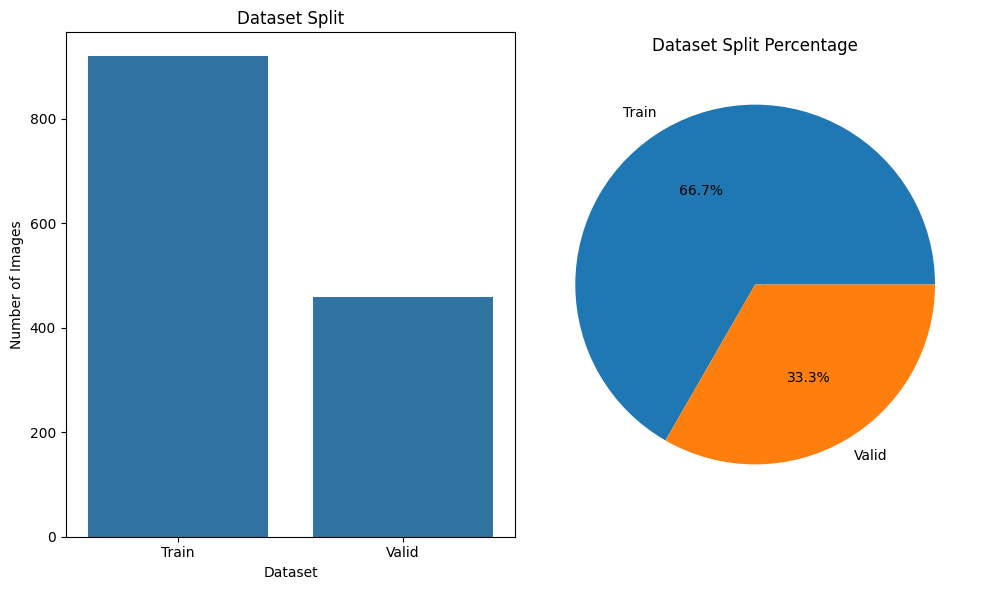

In [27]:
# Plot dataset split
dataset_size = [len(os.listdir(train_image_dir)), len(os.listdir(valid_image_dir))]
plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1)
sns.barplot(x=["Train", "Valid"], y=dataset_size)
plt.xlabel("Dataset")
plt.ylabel("Number of Images")
plt.title("Dataset Split")

plt.subplot(1, 2, 2)
plt.pie(dataset_size, labels=["Train", "Valid"], autopct="%1.1f%%")
plt.title('Dataset Split Percentage')
plt.tight_layout()
plt.show()

In [28]:
# Find duplicate images

train_image_files = os.listdir(train_image_dir)
valid_image_files = os.listdir(valid_image_dir)

duplicate_images = [file for file in train_image_files if file in valid_image_files]
print(f"Duplicate images: {duplicate_images}")
print(f"Duplicate images total length: {len(duplicate_images)}")

Duplicate images: []
Duplicate images total length: 0


In [29]:
# Find duplicate labels

train_label_files = os.listdir(train_label_dir)
valid_label_files = os.listdir(valid_label_dir)

duplicate_labels = [file for file in train_label_files if file in valid_label_files]
print(f"Duplicate labels: {duplicate_labels}")
print(f"Duplicate labels total length: {len(duplicate_labels)}")

Duplicate labels: []
Duplicate labels total length: 0


## 3. Image processing on bounding box